In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='4'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='min_temp'
SAMPLE_SIZE=5000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
ORIGINAL_PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v2', 'profile_list_v2_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v2_experiment_4_20250401_0203


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v2_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 164894/164894 [01:05<00:00, 2499.36it/s]

Saved 164894 profiles to /workspace/outputs/profiles_v2_experiment_4_20250401_0203/20250401-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV2(csv_path, DEVICE)

Loading Profiles: 164894it [00:08, 19328.54it/s]


Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250401_0203/density_plot.png


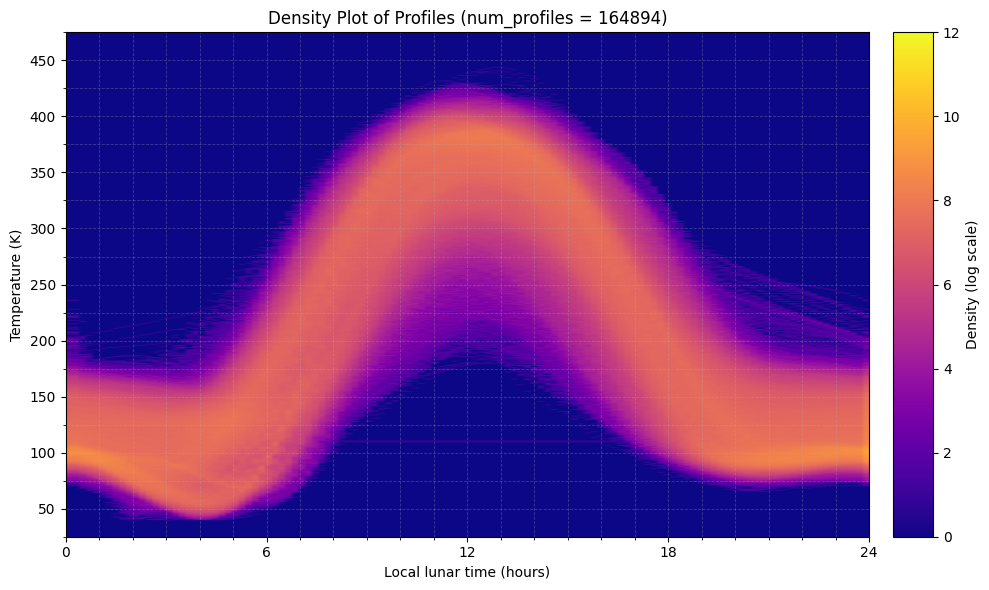

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250401_0203/histogram_max_temp.png


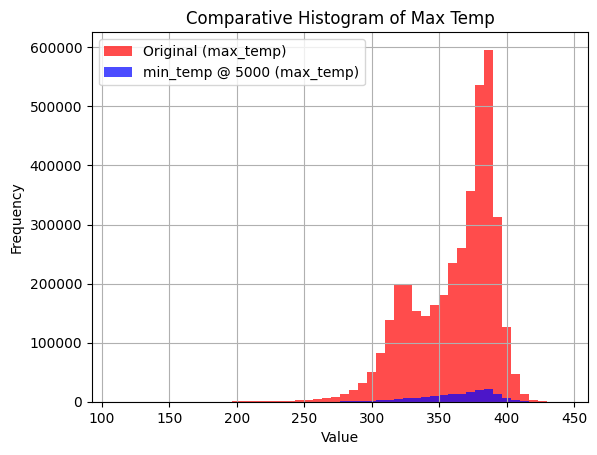

Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250401_0203/histogram_min_temp.png


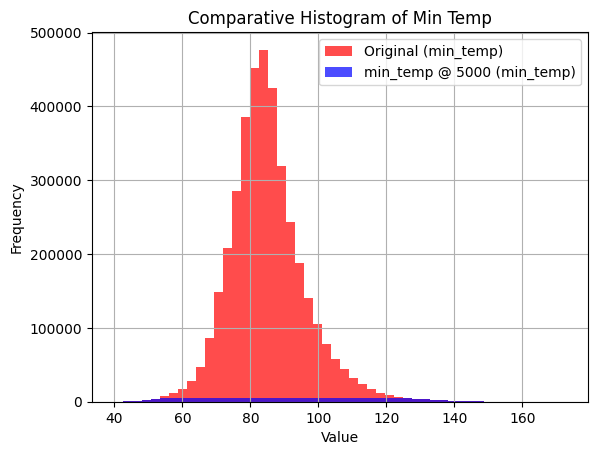

Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250401_0203/histogram_mean_temp.png


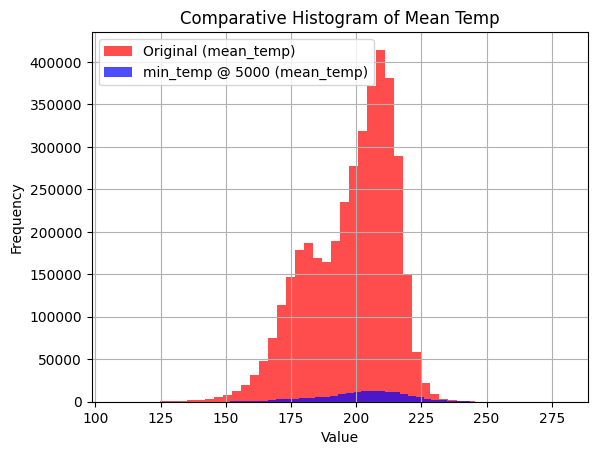

Saved figure to /workspace/outputs/profiles_v2_experiment_4_20250401_0203/histogram_std_temp.png


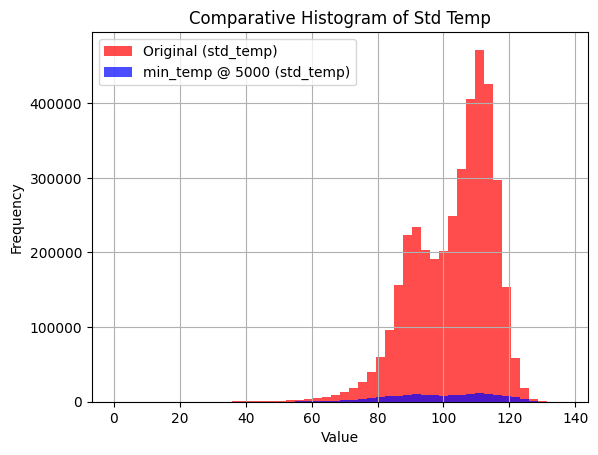

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV2(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV2(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 202.2434
STD: 101.3607
Min Temp: 40.0240
Max Temp: 443.4440
Datasets:
Training Data: 115425
Validation Data: 32978
Test Data: 16491


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 578/578 [00:17<00:00, 33.01it/s, best_loss=0.6372]


[Training] Epoch 1/100, L1 Loss: 0.6319, L2 Loss: 0.6731, KL Loss: 0.4718, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 165/165 [00:01<00:00, 112.46it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5740, Val L2 Loss: 0.5928, Val KL Loss: 0.5264
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_4_20250401_0203'


[Training] Epoch 2/100: 100%|██████████| 578/578 [00:18<00:00, 31.67it/s, best_loss=0.6110]


[Training] Epoch 2/100, L1 Loss: 0.5980, L2 Loss: 0.6238, KL Loss: 0.5284, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 165/165 [00:01<00:00, 118.21it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5654, Val L2 Loss: 0.5865, Val KL Loss: 0.5331
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_4_20250401_0203'


[Training] Epoch 3/100: 100%|██████████| 578/578 [00:18<00:00, 31.59it/s, best_loss=0.5184]


[Training] Epoch 3/100, L1 Loss: 0.5974, L2 Loss: 0.6229, KL Loss: 0.5260, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 165/165 [00:01<00:00, 112.72it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5658, Val L2 Loss: 0.5868, Val KL Loss: 0.5258


[Training] Epoch 4/100: 100%|██████████| 578/578 [00:18<00:00, 31.46it/s, best_loss=0.6165]


[Training] Epoch 4/100, L1 Loss: 0.5977, L2 Loss: 0.6232, KL Loss: 0.5271, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 165/165 [00:01<00:00, 111.99it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5613, Val L2 Loss: 0.5831, Val KL Loss: 0.5356
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_4_20250401_0203'


[Training] Epoch 5/100: 100%|██████████| 578/578 [00:18<00:00, 31.99it/s, best_loss=0.5995]


[Training] Epoch 5/100, L1 Loss: 0.5972, L2 Loss: 0.6225, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 165/165 [00:01<00:00, 112.09it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5643, Val L2 Loss: 0.5857, Val KL Loss: 0.5183


[Training] Epoch 6/100: 100%|██████████| 578/578 [00:18<00:00, 31.64it/s, best_loss=0.5924]


[Training] Epoch 6/100, L1 Loss: 0.5976, L2 Loss: 0.6233, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 165/165 [00:01<00:00, 111.80it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5654, Val L2 Loss: 0.5863, Val KL Loss: 0.5175


[Training] Epoch 7/100: 100%|██████████| 578/578 [00:17<00:00, 32.58it/s, best_loss=0.6132]


[Training] Epoch 7/100, L1 Loss: 0.5977, L2 Loss: 0.6235, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 165/165 [00:01<00:00, 94.05it/s] 


[Validation] Epoch 7/100, Val L1 Loss: 0.5660, Val L2 Loss: 0.5868, Val KL Loss: 0.5205


[Training] Epoch 8/100: 100%|██████████| 578/578 [00:17<00:00, 32.65it/s, best_loss=0.5641]


[Training] Epoch 8/100, L1 Loss: 0.5976, L2 Loss: 0.6231, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 165/165 [00:01<00:00, 106.55it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5658, Val L2 Loss: 0.5870, Val KL Loss: 0.5209


[Training] Epoch 9/100: 100%|██████████| 578/578 [00:18<00:00, 31.16it/s, best_loss=0.5998]


[Training] Epoch 9/100, L1 Loss: 0.5974, L2 Loss: 0.6229, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 165/165 [00:01<00:00, 118.59it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5672, Val L2 Loss: 0.5879, Val KL Loss: 0.5201


[Training] Epoch 10/100: 100%|██████████| 578/578 [00:17<00:00, 32.53it/s, best_loss=0.5663]


[Training] Epoch 10/100, L1 Loss: 0.5974, L2 Loss: 0.6229, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 165/165 [00:01<00:00, 113.65it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5647, Val L2 Loss: 0.5862, Val KL Loss: 0.5280


[Training] Epoch 11/100: 100%|██████████| 578/578 [00:18<00:00, 31.67it/s, best_loss=0.6033]


[Training] Epoch 11/100, L1 Loss: 0.5975, L2 Loss: 0.6230, KL Loss: 0.5274, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 165/165 [00:01<00:00, 111.56it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5648, Val L2 Loss: 0.5859, Val KL Loss: 0.5253


[Training] Epoch 12/100: 100%|██████████| 578/578 [00:18<00:00, 32.08it/s, best_loss=0.6212]


[Training] Epoch 12/100, L1 Loss: 0.5975, L2 Loss: 0.6229, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 165/165 [00:01<00:00, 118.30it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5637, Val L2 Loss: 0.5851, Val KL Loss: 0.5232


[Training] Epoch 13/100: 100%|██████████| 578/578 [00:18<00:00, 31.33it/s, best_loss=0.5590]


[Training] Epoch 13/100, L1 Loss: 0.5973, L2 Loss: 0.6227, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 165/165 [00:01<00:00, 116.91it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5623, Val L2 Loss: 0.5839, Val KL Loss: 0.5311


[Training] Epoch 14/100: 100%|██████████| 578/578 [00:18<00:00, 31.68it/s, best_loss=0.6026]


[Training] Epoch 14/100, L1 Loss: 0.5975, L2 Loss: 0.6231, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 165/165 [00:01<00:00, 118.54it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5625, Val L2 Loss: 0.5840, Val KL Loss: 0.5257


[Training] Epoch 15/100: 100%|██████████| 578/578 [00:18<00:00, 31.15it/s, best_loss=0.6147]


[Training] Epoch 15/100, L1 Loss: 0.5975, L2 Loss: 0.6230, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 165/165 [00:01<00:00, 109.06it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5639, Val L2 Loss: 0.5852, Val KL Loss: 0.5339


[Training] Epoch 16/100: 100%|██████████| 578/578 [00:18<00:00, 31.65it/s, best_loss=0.6022]


[Training] Epoch 16/100, L1 Loss: 0.5975, L2 Loss: 0.6232, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 165/165 [00:01<00:00, 114.68it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5610, Val L2 Loss: 0.5829, Val KL Loss: 0.5243
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_4_20250401_0203'


[Training] Epoch 17/100: 100%|██████████| 578/578 [00:17<00:00, 32.74it/s, best_loss=0.6094]


[Training] Epoch 17/100, L1 Loss: 0.5976, L2 Loss: 0.6234, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 165/165 [00:01<00:00, 113.85it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5630, Val L2 Loss: 0.5845, Val KL Loss: 0.5276


[Training] Epoch 18/100: 100%|██████████| 578/578 [00:18<00:00, 31.65it/s, best_loss=0.5823]


[Training] Epoch 18/100, L1 Loss: 0.5975, L2 Loss: 0.6230, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 165/165 [00:01<00:00, 114.64it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5642, Val L2 Loss: 0.5854, Val KL Loss: 0.5276


[Training] Epoch 19/100: 100%|██████████| 578/578 [00:18<00:00, 32.08it/s, best_loss=0.6216]


[Training] Epoch 19/100, L1 Loss: 0.5975, L2 Loss: 0.6234, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 165/165 [00:01<00:00, 117.56it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5647, Val L2 Loss: 0.5857, Val KL Loss: 0.5195


[Training] Epoch 20/100: 100%|██████████| 578/578 [00:17<00:00, 32.12it/s, best_loss=0.6030]


[Training] Epoch 20/100, L1 Loss: 0.5974, L2 Loss: 0.6231, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 165/165 [00:01<00:00, 110.35it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5622, Val L2 Loss: 0.5839, Val KL Loss: 0.5286


[Training] Epoch 21/100: 100%|██████████| 578/578 [00:17<00:00, 32.33it/s, best_loss=0.5643]


[Training] Epoch 21/100, L1 Loss: 0.5971, L2 Loss: 0.6224, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 165/165 [00:01<00:00, 108.50it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5633, Val L2 Loss: 0.5849, Val KL Loss: 0.5314


[Training] Epoch 22/100: 100%|██████████| 578/578 [00:18<00:00, 32.08it/s, best_loss=0.5964]


[Training] Epoch 22/100, L1 Loss: 0.5977, L2 Loss: 0.6234, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 165/165 [00:01<00:00, 114.07it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5647, Val L2 Loss: 0.5861, Val KL Loss: 0.5208


[Training] Epoch 23/100: 100%|██████████| 578/578 [00:17<00:00, 32.47it/s, best_loss=0.5888]


[Training] Epoch 23/100, L1 Loss: 0.5977, L2 Loss: 0.6232, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 165/165 [00:01<00:00, 87.58it/s] 


[Validation] Epoch 23/100, Val L1 Loss: 0.5646, Val L2 Loss: 0.5859, Val KL Loss: 0.5252


[Training] Epoch 24/100: 100%|██████████| 578/578 [00:18<00:00, 31.82it/s, best_loss=0.6060]


[Training] Epoch 24/100, L1 Loss: 0.5973, L2 Loss: 0.6228, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 165/165 [00:01<00:00, 104.36it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5624, Val L2 Loss: 0.5841, Val KL Loss: 0.5303


[Training] Epoch 25/100: 100%|██████████| 578/578 [00:18<00:00, 31.21it/s, best_loss=0.6119]


[Training] Epoch 25/100, L1 Loss: 0.5975, L2 Loss: 0.6231, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 165/165 [00:01<00:00, 109.91it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5639, Val L2 Loss: 0.5852, Val KL Loss: 0.5225


[Training] Epoch 26/100: 100%|██████████| 578/578 [00:18<00:00, 31.99it/s, best_loss=0.6092]


[Training] Epoch 26/100, L1 Loss: 0.5971, L2 Loss: 0.6227, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 165/165 [00:01<00:00, 112.28it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5635, Val L2 Loss: 0.5851, Val KL Loss: 0.5243


[Training] Epoch 27/100: 100%|██████████| 578/578 [00:18<00:00, 31.52it/s, best_loss=0.6166]


[Training] Epoch 27/100, L1 Loss: 0.5975, L2 Loss: 0.6231, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 165/165 [00:01<00:00, 110.94it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5625, Val L2 Loss: 0.5842, Val KL Loss: 0.5246


[Training] Epoch 28/100: 100%|██████████| 578/578 [00:17<00:00, 32.21it/s, best_loss=0.6140]


[Training] Epoch 28/100, L1 Loss: 0.5973, L2 Loss: 0.6233, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 165/165 [00:01<00:00, 111.06it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5626, Val L2 Loss: 0.5841, Val KL Loss: 0.5274


[Training] Epoch 29/100: 100%|██████████| 578/578 [00:18<00:00, 31.59it/s, best_loss=0.6070]


[Training] Epoch 29/100, L1 Loss: 0.5974, L2 Loss: 0.6228, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 165/165 [00:01<00:00, 110.84it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5636, Val L2 Loss: 0.5850, Val KL Loss: 0.5231


[Training] Epoch 30/100: 100%|██████████| 578/578 [00:17<00:00, 32.56it/s, best_loss=0.5904]


[Training] Epoch 30/100, L1 Loss: 0.5971, L2 Loss: 0.6225, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 165/165 [00:01<00:00, 97.95it/s] 


[Validation] Epoch 30/100, Val L1 Loss: 0.5662, Val L2 Loss: 0.5872, Val KL Loss: 0.5223


[Training] Epoch 31/100: 100%|██████████| 578/578 [00:18<00:00, 31.56it/s, best_loss=0.6188]


[Training] Epoch 31/100, L1 Loss: 0.5974, L2 Loss: 0.6231, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 165/165 [00:01<00:00, 112.07it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5627, Val L2 Loss: 0.5842, Val KL Loss: 0.5342


[Training] Epoch 32/100: 100%|██████████| 578/578 [00:18<00:00, 31.48it/s, best_loss=0.5666]


[Training] Epoch 32/100, L1 Loss: 0.5973, L2 Loss: 0.6226, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 165/165 [00:01<00:00, 114.99it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5641, Val L2 Loss: 0.5854, Val KL Loss: 0.5240


[Training] Epoch 33/100: 100%|██████████| 578/578 [00:18<00:00, 32.04it/s, best_loss=0.6045]


[Training] Epoch 33/100, L1 Loss: 0.5971, L2 Loss: 0.6226, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 165/165 [00:01<00:00, 111.83it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5653, Val L2 Loss: 0.5863, Val KL Loss: 0.5192


[Training] Epoch 34/100: 100%|██████████| 578/578 [00:17<00:00, 32.30it/s, best_loss=0.6212]


[Training] Epoch 34/100, L1 Loss: 0.5972, L2 Loss: 0.6228, KL Loss: 0.5274, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 165/165 [00:01<00:00, 108.24it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5649, Val L2 Loss: 0.5860, Val KL Loss: 0.5221


[Training] Epoch 35/100: 100%|██████████| 578/578 [00:17<00:00, 32.15it/s, best_loss=0.6242]


[Training] Epoch 35/100, L1 Loss: 0.5972, L2 Loss: 0.6227, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 165/165 [00:01<00:00, 107.90it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5629, Val L2 Loss: 0.5845, Val KL Loss: 0.5295


[Training] Epoch 36/100: 100%|██████████| 578/578 [00:17<00:00, 32.15it/s, best_loss=0.6093]


[Training] Epoch 36/100, L1 Loss: 0.5973, L2 Loss: 0.6229, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 165/165 [00:01<00:00, 112.75it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5631, Val L2 Loss: 0.5846, Val KL Loss: 0.5261


[Training] Epoch 37/100: 100%|██████████| 578/578 [00:17<00:00, 32.18it/s, best_loss=0.5405]


[Training] Epoch 37/100, L1 Loss: 0.5970, L2 Loss: 0.6223, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 165/165 [00:01<00:00, 90.53it/s] 


[Validation] Epoch 37/100, Val L1 Loss: 0.5656, Val L2 Loss: 0.5867, Val KL Loss: 0.5260


[Training] Epoch 38/100: 100%|██████████| 578/578 [00:17<00:00, 32.33it/s, best_loss=0.6070]


[Training] Epoch 38/100, L1 Loss: 0.5977, L2 Loss: 0.6234, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 165/165 [00:01<00:00, 119.03it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5641, Val L2 Loss: 0.5856, Val KL Loss: 0.5286


[Training] Epoch 39/100: 100%|██████████| 578/578 [00:17<00:00, 32.12it/s, best_loss=0.6166]


[Training] Epoch 39/100, L1 Loss: 0.5978, L2 Loss: 0.6234, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 165/165 [00:01<00:00, 117.31it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5600, Val L2 Loss: 0.5822, Val KL Loss: 0.5310
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_4_20250401_0203'


[Training] Epoch 40/100: 100%|██████████| 578/578 [00:18<00:00, 31.88it/s, best_loss=0.5986]


[Training] Epoch 40/100, L1 Loss: 0.5974, L2 Loss: 0.6230, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 165/165 [00:01<00:00, 106.94it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5624, Val L2 Loss: 0.5842, Val KL Loss: 0.5240


[Training] Epoch 41/100: 100%|██████████| 578/578 [00:18<00:00, 31.53it/s, best_loss=0.5970]


[Training] Epoch 41/100, L1 Loss: 0.5977, L2 Loss: 0.6237, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 165/165 [00:01<00:00, 112.30it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5646, Val L2 Loss: 0.5859, Val KL Loss: 0.5164


[Training] Epoch 42/100: 100%|██████████| 578/578 [00:18<00:00, 32.11it/s, best_loss=0.5995]


[Training] Epoch 42/100, L1 Loss: 0.5976, L2 Loss: 0.6229, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 165/165 [00:01<00:00, 120.45it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5658, Val L2 Loss: 0.5869, Val KL Loss: 0.5177


[Training] Epoch 43/100: 100%|██████████| 578/578 [00:18<00:00, 31.69it/s, best_loss=0.6013]


[Training] Epoch 43/100, L1 Loss: 0.5975, L2 Loss: 0.6232, KL Loss: 0.5274, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 165/165 [00:01<00:00, 107.45it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5660, Val L2 Loss: 0.5869, Val KL Loss: 0.5232


[Training] Epoch 44/100: 100%|██████████| 578/578 [00:17<00:00, 32.20it/s, best_loss=0.6152]


[Training] Epoch 44/100, L1 Loss: 0.5973, L2 Loss: 0.6227, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 165/165 [00:01<00:00, 90.02it/s] 


[Validation] Epoch 44/100, Val L1 Loss: 0.5655, Val L2 Loss: 0.5865, Val KL Loss: 0.5202


[Training] Epoch 45/100: 100%|██████████| 578/578 [00:18<00:00, 31.53it/s, best_loss=0.6087]


[Training] Epoch 45/100, L1 Loss: 0.5971, L2 Loss: 0.6226, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 165/165 [00:01<00:00, 112.17it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5640, Val L2 Loss: 0.5853, Val KL Loss: 0.5188


[Training] Epoch 46/100: 100%|██████████| 578/578 [00:18<00:00, 32.03it/s, best_loss=0.6088]


[Training] Epoch 46/100, L1 Loss: 0.5977, L2 Loss: 0.6237, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 165/165 [00:01<00:00, 107.94it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5651, Val L2 Loss: 0.5861, Val KL Loss: 0.5207


[Training] Epoch 47/100: 100%|██████████| 578/578 [00:18<00:00, 31.77it/s, best_loss=0.6024]


[Training] Epoch 47/100, L1 Loss: 0.5973, L2 Loss: 0.6229, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 165/165 [00:01<00:00, 109.32it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5672, Val L2 Loss: 0.5877, Val KL Loss: 0.5188


[Training] Epoch 48/100: 100%|██████████| 578/578 [00:18<00:00, 31.02it/s, best_loss=0.6189]


[Training] Epoch 48/100, L1 Loss: 0.5975, L2 Loss: 0.6232, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 165/165 [00:01<00:00, 111.22it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5616, Val L2 Loss: 0.5834, Val KL Loss: 0.5306


[Training] Epoch 49/100: 100%|██████████| 578/578 [00:17<00:00, 32.48it/s, best_loss=0.6111]


[Training] Epoch 49/100, L1 Loss: 0.5976, L2 Loss: 0.6230, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 165/165 [00:01<00:00, 119.94it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5626, Val L2 Loss: 0.5844, Val KL Loss: 0.5335


[Training] Epoch 50/100: 100%|██████████| 578/578 [00:18<00:00, 30.70it/s, best_loss=0.6093]


[Training] Epoch 50/100, L1 Loss: 0.5974, L2 Loss: 0.6229, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 165/165 [00:01<00:00, 110.26it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5651, Val L2 Loss: 0.5861, Val KL Loss: 0.5208


[Training] Epoch 51/100: 100%|██████████| 578/578 [00:18<00:00, 31.98it/s, best_loss=0.6059]


[Training] Epoch 51/100, L1 Loss: 0.5974, L2 Loss: 0.6230, KL Loss: 0.5274, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 165/165 [00:01<00:00, 96.23it/s] 


[Validation] Epoch 51/100, Val L1 Loss: 0.5653, Val L2 Loss: 0.5860, Val KL Loss: 0.5209


[Training] Epoch 52/100: 100%|██████████| 578/578 [00:17<00:00, 32.16it/s, best_loss=0.5940]


[Training] Epoch 52/100, L1 Loss: 0.5977, L2 Loss: 0.6233, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 165/165 [00:01<00:00, 120.70it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5640, Val L2 Loss: 0.5850, Val KL Loss: 0.5230


[Training] Epoch 53/100: 100%|██████████| 578/578 [00:18<00:00, 31.22it/s, best_loss=0.5940]


[Training] Epoch 53/100, L1 Loss: 0.5972, L2 Loss: 0.6226, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 165/165 [00:01<00:00, 112.22it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5678, Val L2 Loss: 0.5880, Val KL Loss: 0.5270


[Training] Epoch 54/100: 100%|██████████| 578/578 [00:18<00:00, 31.99it/s, best_loss=0.4660]


[Training] Epoch 54/100, L1 Loss: 0.5972, L2 Loss: 0.6225, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 165/165 [00:01<00:00, 109.54it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5651, Val L2 Loss: 0.5861, Val KL Loss: 0.5227


[Training] Epoch 55/100: 100%|██████████| 578/578 [00:18<00:00, 31.75it/s, best_loss=0.6023]


[Training] Epoch 55/100, L1 Loss: 0.5977, L2 Loss: 0.6234, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 165/165 [00:01<00:00, 115.37it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5616, Val L2 Loss: 0.5834, Val KL Loss: 0.5302


[Training] Epoch 56/100: 100%|██████████| 578/578 [00:18<00:00, 31.71it/s, best_loss=0.5973]


[Training] Epoch 56/100, L1 Loss: 0.5975, L2 Loss: 0.6231, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 165/165 [00:01<00:00, 113.16it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5637, Val L2 Loss: 0.5851, Val KL Loss: 0.5251


[Training] Epoch 57/100: 100%|██████████| 578/578 [00:18<00:00, 31.78it/s, best_loss=0.6171]


[Training] Epoch 57/100, L1 Loss: 0.5978, L2 Loss: 0.6234, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 165/165 [00:01<00:00, 112.84it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5644, Val L2 Loss: 0.5857, Val KL Loss: 0.5293


[Training] Epoch 58/100: 100%|██████████| 578/578 [00:17<00:00, 32.74it/s, best_loss=0.6088]


[Training] Epoch 58/100, L1 Loss: 0.5972, L2 Loss: 0.6226, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 165/165 [00:01<00:00, 113.16it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5637, Val L2 Loss: 0.5853, Val KL Loss: 0.5276


[Training] Epoch 59/100: 100%|██████████| 578/578 [00:18<00:00, 31.83it/s, best_loss=0.6152]


[Training] Epoch 59/100, L1 Loss: 0.5972, L2 Loss: 0.6226, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 165/165 [00:01<00:00, 112.14it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5656, Val L2 Loss: 0.5865, Val KL Loss: 0.5230


[Training] Epoch 60/100: 100%|██████████| 578/578 [00:18<00:00, 32.04it/s, best_loss=0.5976]


[Training] Epoch 60/100, L1 Loss: 0.5977, L2 Loss: 0.6232, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 165/165 [00:01<00:00, 109.85it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5629, Val L2 Loss: 0.5842, Val KL Loss: 0.5218


[Training] Epoch 61/100: 100%|██████████| 578/578 [00:17<00:00, 32.92it/s, best_loss=0.6112]


[Training] Epoch 61/100, L1 Loss: 0.5972, L2 Loss: 0.6225, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 165/165 [00:01<00:00, 103.02it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5639, Val L2 Loss: 0.5852, Val KL Loss: 0.5243


[Training] Epoch 62/100: 100%|██████████| 578/578 [00:18<00:00, 31.98it/s, best_loss=0.6083]


[Training] Epoch 62/100, L1 Loss: 0.5975, L2 Loss: 0.6229, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 165/165 [00:01<00:00, 106.07it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5631, Val L2 Loss: 0.5847, Val KL Loss: 0.5235


[Training] Epoch 63/100: 100%|██████████| 578/578 [00:17<00:00, 32.24it/s, best_loss=0.6144]


[Training] Epoch 63/100, L1 Loss: 0.5974, L2 Loss: 0.6231, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 165/165 [00:01<00:00, 115.27it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5685, Val L2 Loss: 0.5888, Val KL Loss: 0.5176


[Training] Epoch 64/100: 100%|██████████| 578/578 [00:18<00:00, 31.39it/s, best_loss=0.6113]


[Training] Epoch 64/100, L1 Loss: 0.5975, L2 Loss: 0.6233, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 165/165 [00:01<00:00, 115.62it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5667, Val L2 Loss: 0.5877, Val KL Loss: 0.5201


[Training] Epoch 65/100: 100%|██████████| 578/578 [00:18<00:00, 31.46it/s, best_loss=0.6039]


[Training] Epoch 65/100, L1 Loss: 0.5975, L2 Loss: 0.6229, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 165/165 [00:01<00:00, 111.19it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5653, Val L2 Loss: 0.5863, Val KL Loss: 0.5173


[Training] Epoch 66/100: 100%|██████████| 578/578 [00:18<00:00, 30.97it/s, best_loss=0.6039]


[Training] Epoch 66/100, L1 Loss: 0.5974, L2 Loss: 0.6229, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 165/165 [00:01<00:00, 119.50it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5671, Val L2 Loss: 0.5878, Val KL Loss: 0.5233


[Training] Epoch 67/100: 100%|██████████| 578/578 [00:18<00:00, 32.06it/s, best_loss=0.6023]


[Training] Epoch 67/100, L1 Loss: 0.5974, L2 Loss: 0.6230, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 165/165 [00:01<00:00, 88.97it/s] 


[Validation] Epoch 67/100, Val L1 Loss: 0.5638, Val L2 Loss: 0.5852, Val KL Loss: 0.5240


[Training] Epoch 68/100: 100%|██████████| 578/578 [00:18<00:00, 31.76it/s, best_loss=0.6059]


[Training] Epoch 68/100, L1 Loss: 0.5973, L2 Loss: 0.6231, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 165/165 [00:01<00:00, 110.32it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5646, Val L2 Loss: 0.5858, Val KL Loss: 0.5270


[Training] Epoch 69/100: 100%|██████████| 578/578 [00:18<00:00, 31.00it/s, best_loss=0.5955]


[Training] Epoch 69/100, L1 Loss: 0.5976, L2 Loss: 0.6232, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 165/165 [00:01<00:00, 112.88it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5669, Val L2 Loss: 0.5878, Val KL Loss: 0.5197


[Training] Epoch 70/100: 100%|██████████| 578/578 [00:18<00:00, 31.84it/s, best_loss=0.6067]


[Training] Epoch 70/100, L1 Loss: 0.5976, L2 Loss: 0.6232, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 165/165 [00:01<00:00, 104.23it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5655, Val L2 Loss: 0.5865, Val KL Loss: 0.5225


[Training] Epoch 71/100: 100%|██████████| 578/578 [00:18<00:00, 30.57it/s, best_loss=0.6228]


[Training] Epoch 71/100, L1 Loss: 0.5975, L2 Loss: 0.6236, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 165/165 [00:01<00:00, 111.05it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5636, Val L2 Loss: 0.5849, Val KL Loss: 0.5243


[Training] Epoch 72/100: 100%|██████████| 578/578 [00:18<00:00, 31.42it/s, best_loss=0.6160]


[Training] Epoch 72/100, L1 Loss: 0.5972, L2 Loss: 0.6228, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 165/165 [00:01<00:00, 109.79it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5662, Val L2 Loss: 0.5871, Val KL Loss: 0.5202


[Training] Epoch 73/100: 100%|██████████| 578/578 [00:18<00:00, 31.26it/s, best_loss=0.5955]


[Training] Epoch 73/100, L1 Loss: 0.5972, L2 Loss: 0.6228, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 165/165 [00:01<00:00, 115.88it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5668, Val L2 Loss: 0.5878, Val KL Loss: 0.5150


[Training] Epoch 74/100: 100%|██████████| 578/578 [00:17<00:00, 32.14it/s, best_loss=0.6306]


[Training] Epoch 74/100, L1 Loss: 0.5978, L2 Loss: 0.6231, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 165/165 [00:01<00:00, 88.93it/s] 


[Validation] Epoch 74/100, Val L1 Loss: 0.5617, Val L2 Loss: 0.5836, Val KL Loss: 0.5267


[Training] Epoch 75/100: 100%|██████████| 578/578 [00:18<00:00, 31.47it/s, best_loss=0.5979]


[Training] Epoch 75/100, L1 Loss: 0.5973, L2 Loss: 0.6227, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 165/165 [00:01<00:00, 103.66it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5661, Val L2 Loss: 0.5872, Val KL Loss: 0.5194


[Training] Epoch 76/100: 100%|██████████| 578/578 [00:18<00:00, 31.54it/s, best_loss=0.6027]


[Training] Epoch 76/100, L1 Loss: 0.5974, L2 Loss: 0.6229, KL Loss: 0.5274, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 165/165 [00:01<00:00, 115.93it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5632, Val L2 Loss: 0.5846, Val KL Loss: 0.5216


[Training] Epoch 77/100: 100%|██████████| 578/578 [00:18<00:00, 31.57it/s, best_loss=0.6093]


[Training] Epoch 77/100, L1 Loss: 0.5973, L2 Loss: 0.6229, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 165/165 [00:01<00:00, 109.84it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5627, Val L2 Loss: 0.5843, Val KL Loss: 0.5297


[Training] Epoch 78/100: 100%|██████████| 578/578 [00:18<00:00, 30.82it/s, best_loss=0.6143]


[Training] Epoch 78/100, L1 Loss: 0.5976, L2 Loss: 0.6232, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 165/165 [00:01<00:00, 111.37it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5631, Val L2 Loss: 0.5846, Val KL Loss: 0.5278


[Training] Epoch 79/100: 100%|██████████| 578/578 [00:18<00:00, 31.68it/s, best_loss=0.5663]


[Training] Epoch 79/100, L1 Loss: 0.5976, L2 Loss: 0.6227, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 165/165 [00:01<00:00, 113.54it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5632, Val L2 Loss: 0.5848, Val KL Loss: 0.5258


[Training] Epoch 80/100: 100%|██████████| 578/578 [00:18<00:00, 30.70it/s, best_loss=0.6199]


[Training] Epoch 80/100, L1 Loss: 0.5975, L2 Loss: 0.6231, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 165/165 [00:01<00:00, 113.05it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5662, Val L2 Loss: 0.5872, Val KL Loss: 0.5244


[Training] Epoch 81/100: 100%|██████████| 578/578 [00:18<00:00, 31.35it/s, best_loss=0.6081]


[Training] Epoch 81/100, L1 Loss: 0.5975, L2 Loss: 0.6228, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 165/165 [00:01<00:00, 92.02it/s] 


[Validation] Epoch 81/100, Val L1 Loss: 0.5638, Val L2 Loss: 0.5851, Val KL Loss: 0.5230


[Training] Epoch 82/100: 100%|██████████| 578/578 [00:18<00:00, 31.53it/s, best_loss=0.5905]


[Training] Epoch 82/100, L1 Loss: 0.5974, L2 Loss: 0.6230, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 165/165 [00:01<00:00, 113.36it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5664, Val L2 Loss: 0.5870, Val KL Loss: 0.5196


[Training] Epoch 83/100: 100%|██████████| 578/578 [00:18<00:00, 31.26it/s, best_loss=0.6197]


[Training] Epoch 83/100, L1 Loss: 0.5974, L2 Loss: 0.6231, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 165/165 [00:01<00:00, 105.19it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5641, Val L2 Loss: 0.5854, Val KL Loss: 0.5170


[Training] Epoch 84/100: 100%|██████████| 578/578 [00:18<00:00, 31.47it/s, best_loss=0.6243]


[Training] Epoch 84/100, L1 Loss: 0.5976, L2 Loss: 0.6232, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 165/165 [00:01<00:00, 108.73it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5650, Val L2 Loss: 0.5862, Val KL Loss: 0.5286


[Training] Epoch 85/100: 100%|██████████| 578/578 [00:18<00:00, 31.19it/s, best_loss=0.6061]


[Training] Epoch 85/100, L1 Loss: 0.5972, L2 Loss: 0.6229, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 165/165 [00:01<00:00, 116.50it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5636, Val L2 Loss: 0.5850, Val KL Loss: 0.5256


[Training] Epoch 86/100: 100%|██████████| 578/578 [00:18<00:00, 31.91it/s, best_loss=0.6106]


[Training] Epoch 86/100, L1 Loss: 0.5977, L2 Loss: 0.6236, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 165/165 [00:01<00:00, 116.01it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5629, Val L2 Loss: 0.5845, Val KL Loss: 0.5310


[Training] Epoch 87/100: 100%|██████████| 578/578 [00:18<00:00, 30.82it/s, best_loss=0.6051]


[Training] Epoch 87/100, L1 Loss: 0.5976, L2 Loss: 0.6234, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 165/165 [00:01<00:00, 109.97it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5638, Val L2 Loss: 0.5853, Val KL Loss: 0.5249


[Training] Epoch 88/100: 100%|██████████| 578/578 [00:18<00:00, 31.67it/s, best_loss=0.6042]


[Training] Epoch 88/100, L1 Loss: 0.5974, L2 Loss: 0.6230, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 165/165 [00:01<00:00, 88.86it/s] 


[Validation] Epoch 88/100, Val L1 Loss: 0.5676, Val L2 Loss: 0.5882, Val KL Loss: 0.5194


[Training] Epoch 89/100: 100%|██████████| 578/578 [00:17<00:00, 32.40it/s, best_loss=0.6154]


[Training] Epoch 89/100, L1 Loss: 0.5976, L2 Loss: 0.6231, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 165/165 [00:01<00:00, 110.45it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5629, Val L2 Loss: 0.5846, Val KL Loss: 0.5253


[Training] Epoch 90/100: 100%|██████████| 578/578 [00:18<00:00, 30.99it/s, best_loss=0.5748]


[Training] Epoch 90/100, L1 Loss: 0.5975, L2 Loss: 0.6233, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 165/165 [00:01<00:00, 112.62it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5634, Val L2 Loss: 0.5850, Val KL Loss: 0.5290


[Training] Epoch 91/100: 100%|██████████| 578/578 [00:18<00:00, 31.34it/s, best_loss=0.5973]


[Training] Epoch 91/100, L1 Loss: 0.5976, L2 Loss: 0.6232, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 165/165 [00:01<00:00, 108.83it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5662, Val L2 Loss: 0.5870, Val KL Loss: 0.5231


[Training] Epoch 92/100: 100%|██████████| 578/578 [00:18<00:00, 31.39it/s, best_loss=0.6126]


[Training] Epoch 92/100, L1 Loss: 0.5976, L2 Loss: 0.6232, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 165/165 [00:01<00:00, 109.03it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5646, Val L2 Loss: 0.5860, Val KL Loss: 0.5176


[Training] Epoch 93/100: 100%|██████████| 578/578 [00:18<00:00, 31.37it/s, best_loss=0.6152]


[Training] Epoch 93/100, L1 Loss: 0.5973, L2 Loss: 0.6230, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 165/165 [00:01<00:00, 107.62it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5624, Val L2 Loss: 0.5839, Val KL Loss: 0.5298


[Training] Epoch 94/100: 100%|██████████| 578/578 [00:18<00:00, 31.06it/s, best_loss=0.6084]


[Training] Epoch 94/100, L1 Loss: 0.5975, L2 Loss: 0.6231, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 165/165 [00:01<00:00, 110.49it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5649, Val L2 Loss: 0.5859, Val KL Loss: 0.5251


[Training] Epoch 95/100: 100%|██████████| 578/578 [00:18<00:00, 31.54it/s, best_loss=0.6180]


[Training] Epoch 95/100, L1 Loss: 0.5976, L2 Loss: 0.6229, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 165/165 [00:01<00:00, 92.29it/s] 


[Validation] Epoch 95/100, Val L1 Loss: 0.5636, Val L2 Loss: 0.5851, Val KL Loss: 0.5255


[Training] Epoch 96/100: 100%|██████████| 578/578 [00:18<00:00, 31.44it/s, best_loss=0.6142]


[Training] Epoch 96/100, L1 Loss: 0.5977, L2 Loss: 0.6234, KL Loss: 0.5274, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 165/165 [00:01<00:00, 108.51it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5640, Val L2 Loss: 0.5852, Val KL Loss: 0.5195


[Training] Epoch 97/100: 100%|██████████| 578/578 [00:19<00:00, 30.24it/s, best_loss=0.6011]


[Training] Epoch 97/100, L1 Loss: 0.5976, L2 Loss: 0.6232, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 165/165 [00:01<00:00, 108.38it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5629, Val L2 Loss: 0.5844, Val KL Loss: 0.5251


[Training] Epoch 98/100: 100%|██████████| 578/578 [00:18<00:00, 31.71it/s, best_loss=0.5519]


[Training] Epoch 98/100, L1 Loss: 0.5974, L2 Loss: 0.6229, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 165/165 [00:01<00:00, 115.72it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5642, Val L2 Loss: 0.5854, Val KL Loss: 0.5265


[Training] Epoch 99/100: 100%|██████████| 578/578 [00:18<00:00, 30.64it/s, best_loss=0.6165]


[Training] Epoch 99/100, L1 Loss: 0.5973, L2 Loss: 0.6229, KL Loss: 0.5272, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 165/165 [00:01<00:00, 108.11it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5640, Val L2 Loss: 0.5854, Val KL Loss: 0.5253


[Training] Epoch 100/100: 100%|██████████| 578/578 [00:18<00:00, 31.43it/s, best_loss=0.6154]


[Training] Epoch 100/100, L1 Loss: 0.5974, L2 Loss: 0.6231, KL Loss: 0.5273, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 165/165 [00:01<00:00, 107.46it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5626, Val L2 Loss: 0.5844, Val KL Loss: 0.5238


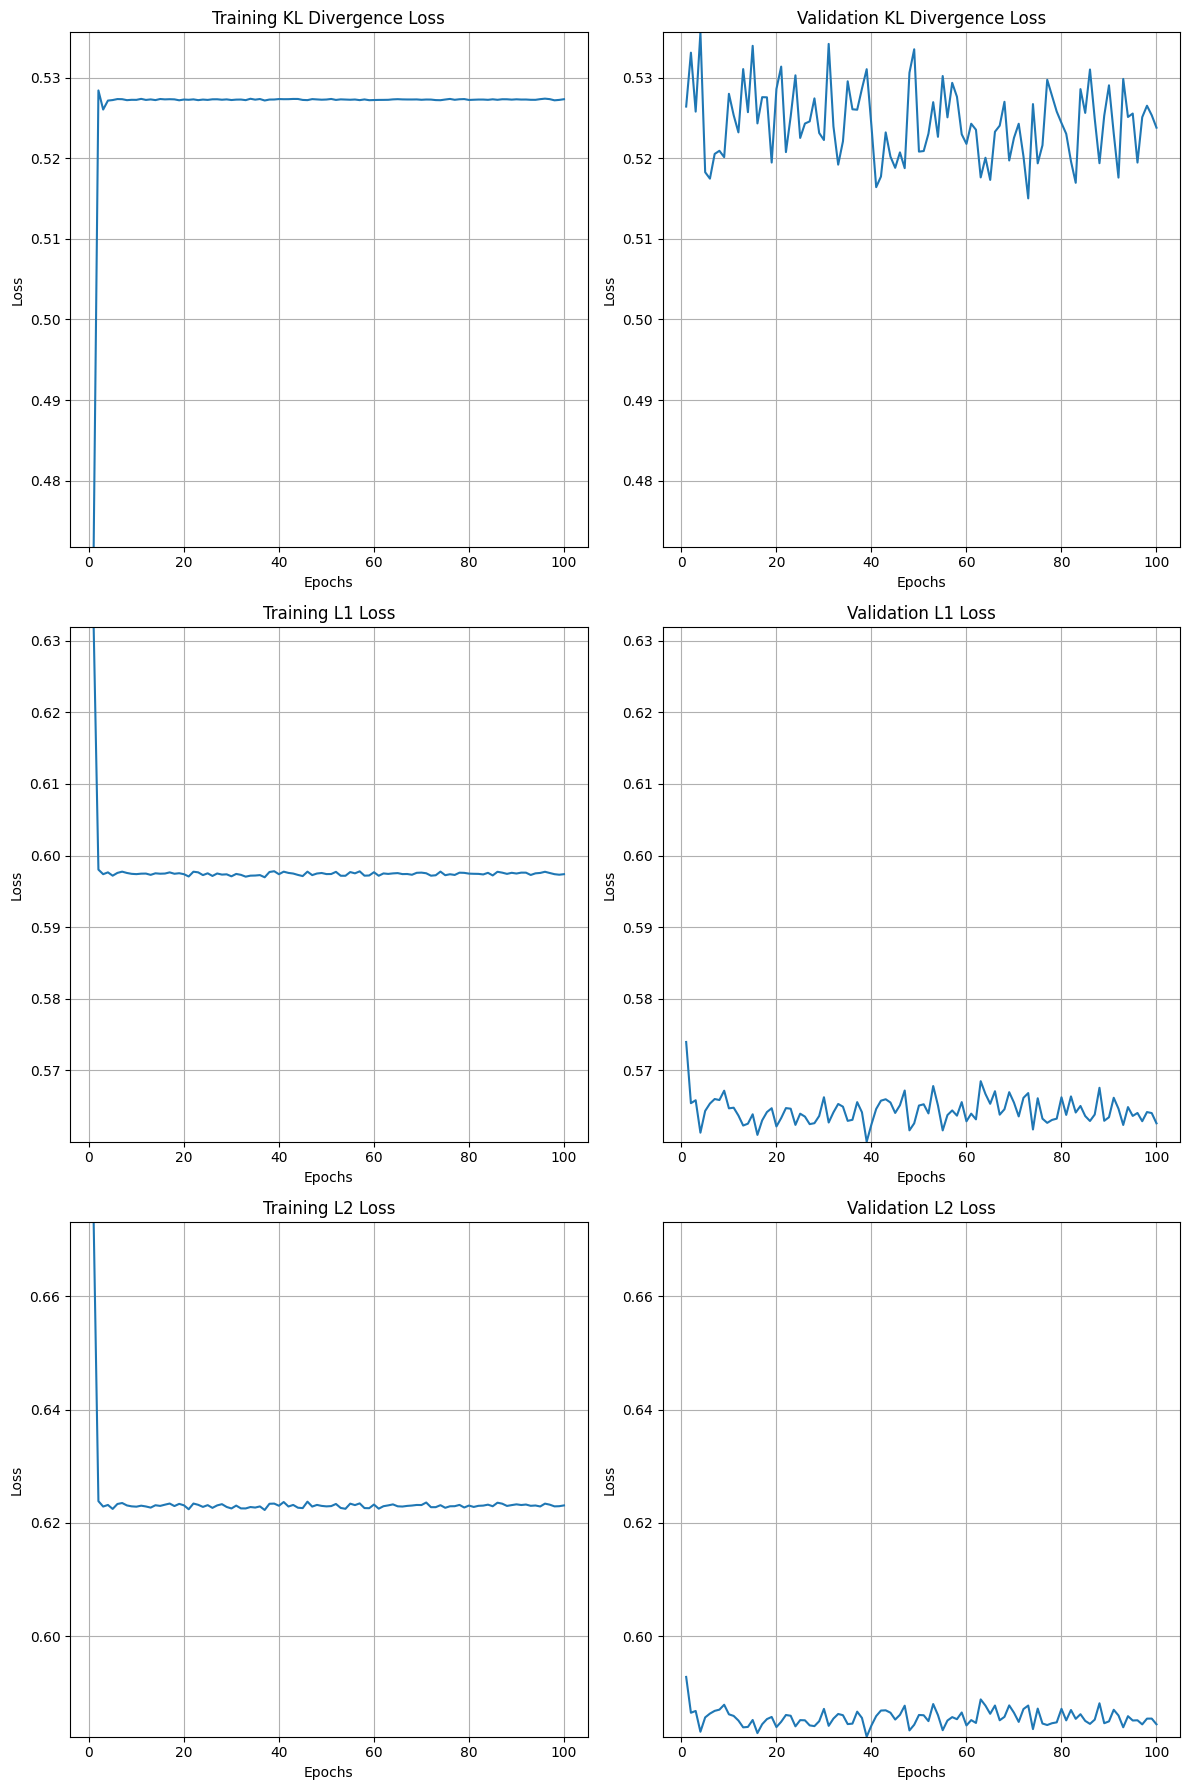

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
56.7643 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


z0: -0.0424
z1: -0.0369
z2: 0.0006
z3: 0.0085


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 748.27it/s]


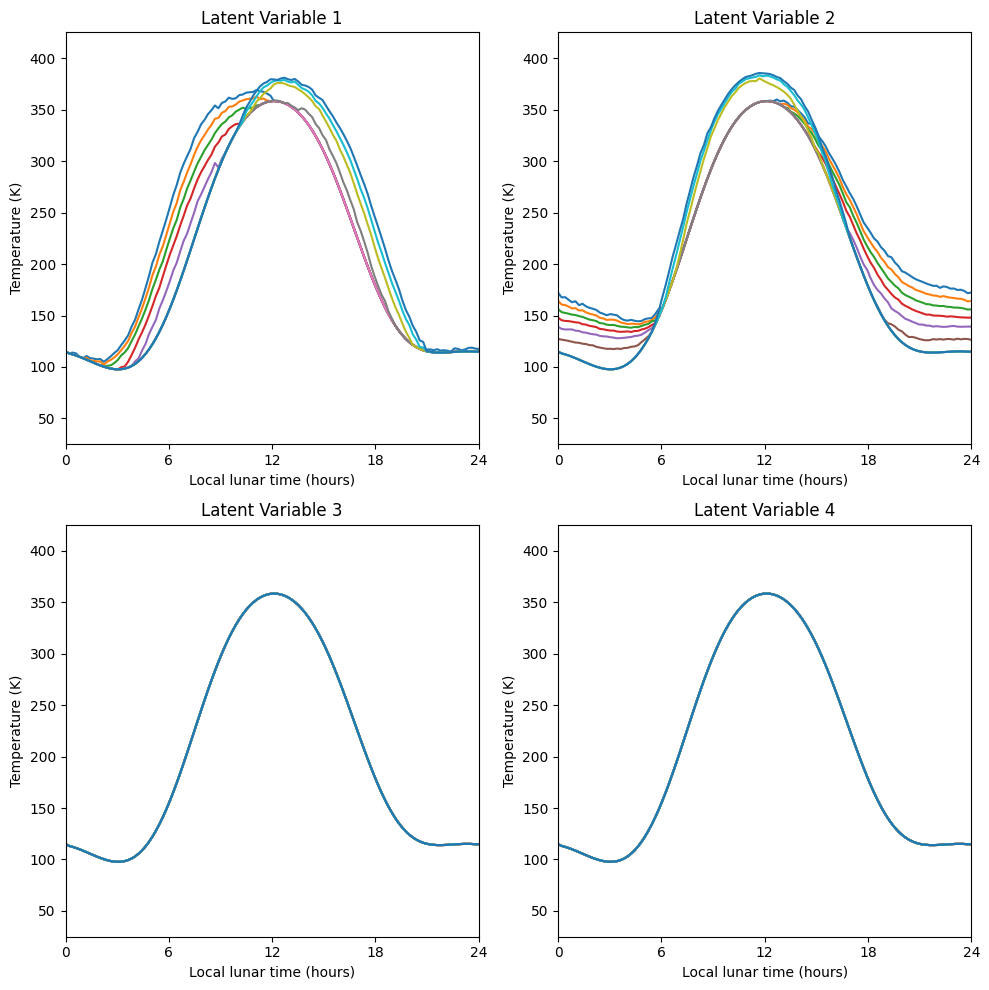

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)